In [46]:
pip install mysql-connector-python

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [15]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items') # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='123',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/Bhavika/Downloads/Datasets/Datasets/Ecommerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns


db = mysql.connector.connect(host = "localhost", 
                             username = "root", 
                             password = "March@07", 
                             database = "ecommerce")

cur = db.cursor()

### List all unique cities where customers are located.

In [17]:
query = """select distinct customer_city from customers"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns =["city"])
df

,city
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


### Count the number of orders placed in 2017.

In [11]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """

cur.execute(query)

data = cur.fetchall()

data[0][0]

135303

### Find the total sales per category.

In [10]:
query = """SELECT 
    upper(p.product_category), ROUND(SUM(py.payment_value), 2) AS sales
FROM
    order_items AS o
        JOIN
    products AS p ON o.product_id = p.product_id
        JOIN
    payments AS py ON o.order_id = py.order_id
GROUP BY p.product_category
ORDER BY sales DESC; """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns =['Category', 'sales'])
df

,Category,sales
0,BED TABLE BATH,20550644.05
1,HEALTH BEAUTY,19888477.43
2,COMPUTER ACCESSORIES,19023965.36
3,FURNITURE DECORATION,17162116.70
4,WATCHES PRESENT,17150600.14
...,...,...
69,PC GAMER,26093.16
70,HOUSE COMFORT 2,20526.48
71,CDS MUSIC DVDS,14393.16
72,FASHION CHILDREN'S CLOTHING,9428.04


### Calculate the percentage of orders that were paid in installments.

In [17]:
query = """select (sum(case when payment_installments > 1 then 1 else 0 end))/count(*)*100 as installments_percentage from payments;"""

cur.execute(query)

data = cur.fetchall()

data

[(Decimal('49.4176'),)]

### Count the number of customers from each state.

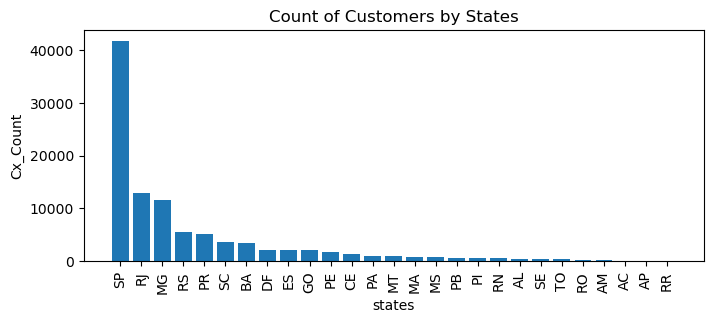

In [39]:
query = """select customer_state, count(customer_id) from customers
group by customer_state """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["state", "customer_count"])
# df
df = df.sort_values(by = "customer_count", ascending=False)
plt.figure(figsize = (8,3))

plt.bar(df["state"], df["customer_count"])
plt.xticks(rotation=90)
plt.xlabel("states")
plt.ylabel("Cx_Count")
plt.title("Count of Customers by States")
plt.show()


### Calculate the number of orders per month in 2018.

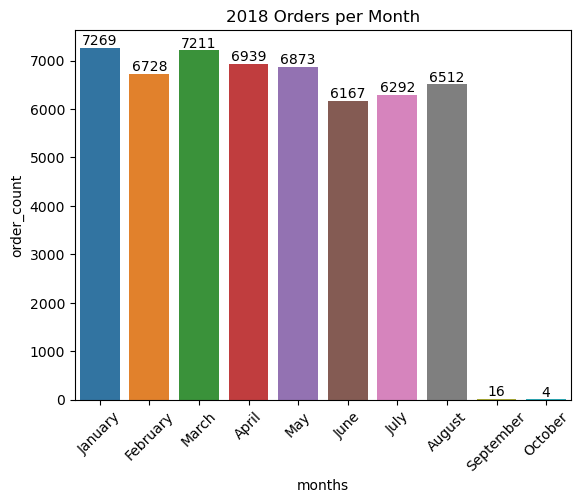

In [40]:
query = """ SELECT 
    MONTHNAME(order_purchase_timestamp) months, COUNT(order_id)
FROM
    orders
WHERE
    YEAR(order_purchase_timestamp) = 2018
GROUP BY months; """

cur.execute(query)

data = cur.fetchall()

df=pd.DataFrame(data, columns=["months", "order_count"])
o = ['January','February','March','April','May','June','July','August','September','October']

ax= sns.barplot(x= df["months"], y= df["order_count"], data = df, order = o)
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("2018 Orders per Month")

plt.show()

### Find the average number of products per order, grouped by customer city.

In [44]:
query = """ with count_per_order as
(SELECT 
    o.order_id, o.customer_id, COUNT(ot.order_id) AS oc
FROM
    orders AS o
        JOIN
    order_items AS ot ON o.order_id = ot.order_id
GROUP BY o.order_id , o.customer_id)

SELECT 
    c.customer_city,
    ROUND(AVG(count_per_order.oc), 2) average_orders
FROM
    customers AS c
        JOIN
    count_per_order ON c.customer_id = count_per_order.customer_id
GROUP BY c.customer_city; """

cur.execute(query)

data = cur.fetchall()
df=pd.DataFrame(data, columns = ["Cx_City", "Avg_items_in_an_order"])
df

,Cx_City,Avg_items_in_an_order
0,sao paulo,1.16
1,sao jose dos campos,1.14
2,porto alegre,1.17
3,indaial,1.12
4,treze tilias,1.27
...,...,...
4105,japaratuba,1.00
4106,sebastiao leal,1.00
4107,buriti,3.00
4108,morro agudo de goias,1.00


### Calculate the percentage of total revenue contributed by each product category.

In [18]:
query = """ SELECT 
    p.product_category,
    ROUND((SUM(py.payment_value) / (SELECT 
                    SUM(payment_value)
                FROM
                    payments)) * 100,
            2) AS sales_percentage
FROM
    order_items AS o
        JOIN
    products AS p ON o.product_id = p.product_id
        JOIN
    payments AS py ON py.order_id = o.order_id
GROUP BY p.product_category
order by sales_percentage desc; """

cur.execute(query)

data = cur.fetchall()
df=pd.DataFrame(data, columns= ['Category', 'Sales_Percentage'])
df

,Category,Sales_Percentage
0,bed table bath,10.70
1,HEALTH BEAUTY,10.35
2,computer accessories,9.90
3,Furniture Decoration,8.93
4,Watches present,8.93
...,...,...
69,House Comfort 2,0.01
70,cds music dvds,0.01
71,PC Gamer,0.01
72,Fashion Children's Clothing,0.00


### Identify the correlation between product price and the number of times a product has been purchased.

In [20]:
import numpy as np

In [21]:
query = """ SELECT 
    p.product_category,
    COUNT(o.product_id),
    ROUND(AVG(o.price), 2)
FROM
    products AS p
        JOIN
    order_items AS o ON p.product_id = o.product_id
GROUP BY P.product_category; """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Category", "Order_count", "Price"  ])
df

arr1 = df["Order_count"]
arr2 = df["Price"]

np.corrcoef([arr1,arr2])


array([[ 1.        , -0.10631514],
       [-0.10631514,  1.        ]])

### Calculate the total revenue generated by each seller, and rank them by revenue.

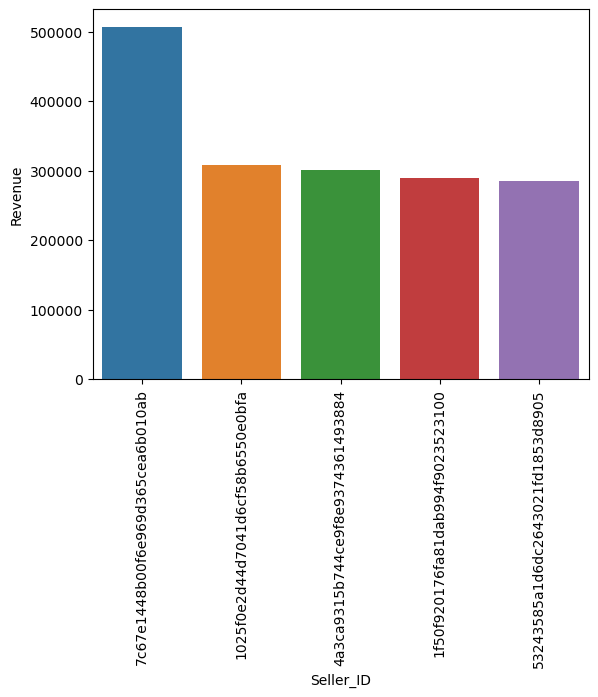

In [29]:
query = """ SELECT *, dense_rank() OVER(order by revenue DESC) AS Ranks FROM
(SELECT 
    o.seller_id, round(SUM(p.payment_value),2) AS revenue
FROM
    order_items AS o
        JOIN
    payments AS p ON o.order_id = p.order_id
GROUP BY o.seller_id) AS a; """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Seller_ID", "Revenue", "Rank"  ])
df.head()

sns.barplot(x= "Seller_ID", y="Revenue", data=df.head())
plt.xticks(rotation=90)
plt.show()

### Calculate the moving average of order values for each customer over their order history.

In [31]:
query = """ select customer_id, order_purchase_timestamp,payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp 
rows between 2 preceding and current row) as Moving_Avg 
from
(select o.customer_id, o.order_purchase_timestamp, p.payment_value as payment
from orders as o join payments as p
on o.order_id=p.order_id) as a; """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["customer_id", "order_purchase_timestamp", "payment", "Moving_Avg" ])
df

# Cx who placed single order will have default same moving avg as payemnt col
# check SQL code and table for this question to get more clarity

,customer_id,order_purchase_timestamp,payment,Moving_Avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


### Calculate the cumulative sales per month for each year.

In [40]:
query = """ SELECT Years, Months,Payments, SUM(Payments)
OVER(ORDER BY Years,Months) AS cumulative_sales
FROM
(SELECT 
    YEAR(o.order_purchase_timestamp) AS Years,
    MONTH(o.order_purchase_timestamp) AS Months,
    ROUND(SUM(p.Payment_value), 2) AS Payments
FROM
    orders AS o
        JOIN
    payments AS p 
    ON o.order_id = p.order_id
GROUP BY Years , Months
ORDER BY Years , Months) AS a; """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Years", "Months", "Payments", "cumulative_sales" ])
df

#plt.plot(df["Months"], df["Years"])  

#plt.xlabel("Months")
#plt.ylabel("Years")
#plt.title("Cumulative Sales per Month for Each Year")

#plt.show()



,Years,Months,Payments,cumulative_sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


### Calculate the year-over-year growth rate of total sales.

In [60]:
query = """ WITH a AS
(SELECT 
    YEAR(o.order_purchase_timestamp) AS Years,
    ROUND(SUM(p.Payment_value), 2) AS Payments
FROM
    orders AS o
        JOIN
    payments AS p 
    ON o.order_id = p.order_id
GROUP BY Years 
ORDER BY Years)
SELECT Years, (Payments - lag(payments, 1) over(order by Years))/
lag(payments, 1) over(order by Years) * 100 from a;  """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Years", "YOY_Growth" ])
df

,Years,YOY_Growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


### Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [58]:
query = """ with a as
(select c.customer_id, min(o.order_purchase_timestamp) as first_order
from customers as c join orders as o
on c.customer_id = o.customer_id
group by c.customer_id),

b as (select a.customer_id, count(distinct o.order_purchase_timestamp)
from a join orders as o
on o.customer_id=a.customer_id
and o.order_purchase_timestamp > first_order
and o.order_purchase_timestamp < date_add(first_order, interval 6 month)
group by a.customer_id)

select 100 * count(distinct a.customer_id)/ count(distinct b.customer_id)
from a left join b
on a.customer_id=b.customer_id;  """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data)
df

,0
0,None


### Identify the top 3 customers who spent the most money in each year.

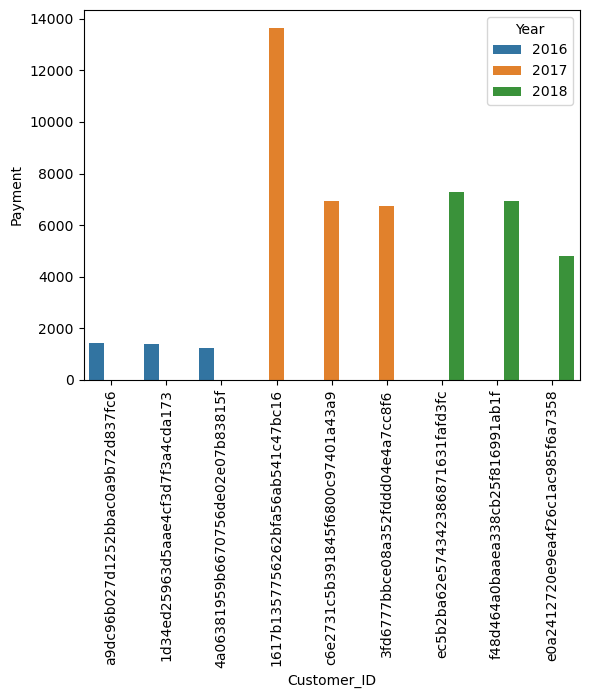

In [59]:
query = """ SELECT Years, customer_id, payment, d_rank FROM
(SELECT 
    YEAR(o.order_purchase_timestamp) Years,
    o.customer_id, SUM(p.payment_value) AS payment,
    DENSE_RANK() OVER(partition by YEAR(o.order_purchase_timestamp) ORDER BY SUM(p.payment_value) DESC) d_rank
FROM
    orders AS o
        JOIN
    payments AS p ON o.order_id = p.order_id
GROUP BY YEAR(o.order_purchase_timestamp), o.customer_id) AS a
WHERE d_rank <= 3;  """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Year", "Customer_ID","Payment","Rank" ])
df
sns.barplot(x = "Customer_ID", y= "Payment", data=df, hue= "Year")
plt.xticks(rotation=90)
plt.show()